# AWS Performance

This notebook contains a comparison of Whisper on the [RDS GPU Workstation](https://docs.google.com/document/d/1k4fTuLUpT1S7WGtYTLPdE9pI_UwffiOW4-lcJKpIaW0/edit#heading=h.k6w3eccrwgdq) and an AWS instance (g4dn.xlarge). The [g4dn.xlarge] has 1 NVIDIA T4 GPU, 16 vCPUs and 64GB of RAM. 

First we need to get the results from the GPU workstation, and limit to the run for the Whisper options we have decided to use.

In [45]:
import pandas

rds = pandas.read_csv('../docs/output-2024-04-11/report-whisper.csv')
rds = rds[rds['options'] == "{'model_name': 'large', 'beam_size': 5, 'patience': 1.0, 'condition_on_previous_text': False, 'best_of': 5}"]
rds = rds[['druid', 'runtime']]
rds.columns = ['druid', 'runtime_rds']
rds


,druid,runtime_rds
8,bb158br2509,219.484938
54,bg405cn7261,88.899626
100,bw689yg2740,585.138051
160,fh290wd1772,15.008326
208,gj097zq7635,364.681268
268,gk220dt2833,50.418620
302,gn213vd3845,36.881981
336,kp010zv7055,51.779526
384,qf378nj5000,294.352984
456,tc482fh1865,30.908619


A run of the same input files with the same options was performed on the EC2 instance and the results were saved as a CSV.

In [46]:
ec2 = pandas.read_csv('../docs/output-2024-04-11/report-whisper-g4dn-xlarge.csv')
ec2 = ec2[['druid', 'runtime']]
ec2.columns = ['druid', 'runtime_ec2']
ec2

,druid,runtime_ec2
0,bb158br2509,463.665833
1,bg405cn7261,182.284887
2,br525sp8033,61.801358
3,bw689yg2740,1214.899954
4,fh290wd1772,30.836149
5,gj097zq7635,740.105561
6,gk220dt2833,103.381342
7,gn213vd3845,75.864730
8,kp010zv7055,159.372658
9,qf378nj5000,597.172941


In [47]:
results = rds.join(ec2.set_index('druid'), on='druid')
results

,druid,runtime_rds,runtime_ec2
8,bb158br2509,219.484938,463.665833
54,bg405cn7261,88.899626,182.284887
100,bw689yg2740,585.138051,1214.899954
160,fh290wd1772,15.008326,30.836149
208,gj097zq7635,364.681268,740.105561
268,gk220dt2833,50.418620,103.381342
302,gn213vd3845,36.881981,75.864730
336,kp010zv7055,51.779526,159.372658
384,qf378nj5000,294.352984,597.172941
456,tc482fh1865,30.908619,63.385072


We can plot the runtimes as a bar chart.

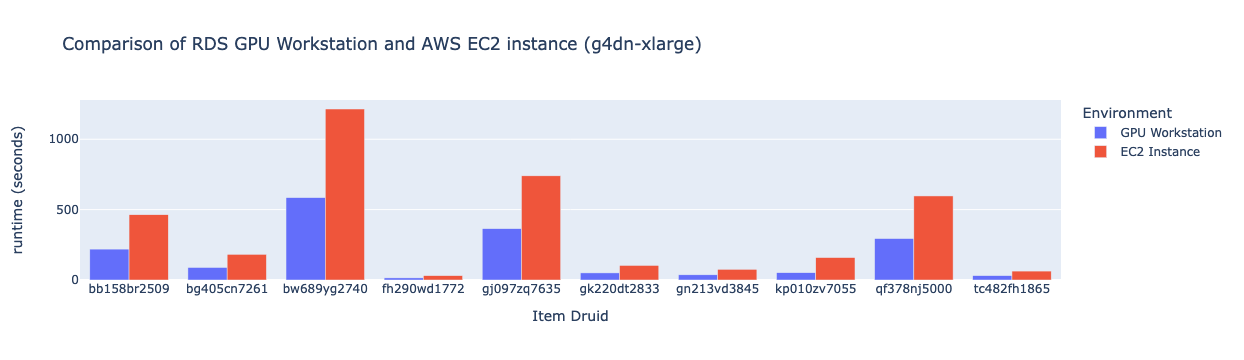

In [48]:
from plotly import express as xp

fig = xp.bar(
    results.set_index('druid'),
    barmode='group',
    labels={
        'value': 'runtime (seconds)',
        'druid': 'Item Druid',
        'variable': 'Environment'
    },
    title='Comparison of RDS GPU Workstation and AWS EC2 instance (g4dn-xlarge)'
)
fig.data[0].name = 'GPU Workstation'
fig.data[1].name = 'EC2 Instance'
fig

In [49]:
results.runtime_ec2.mean()

363.0969127

In [50]:
results.runtime_rds.mean()

173.7553939

Maybe paying for the G4ad series instance would provide comparable performance since [the docs] say it is 45% faster than G4ld.

In [52]:
results.runtime_ec2.mean() / results.runtime_rds.mean()

2.089701531274305

## Processing Rate

The processing rate can be calculated with the Duration column in the SDR dataset:

In [56]:
sdr = pandas.read_csv('../sdr-data.csv')
sdr = sdr[['Druid', 'Duration']]
sdr.columns = ['druid', 'duration']
sdr

,druid,duration
0,bb158br2509,1842
1,bg405cn7261,655
2,bh446wm7842,9642
3,br525sp8033,471
4,bw689yg2740,5080
5,gj097zq7635,2849
6,tc482fh1865,246
7,gk220dt2833,4463
8,qf378nj5000,2294
9,fh290wd1772,133


In [58]:
results = results.join(sdr.set_index('druid'), on='druid')
results

,druid,runtime_rds,runtime_ec2,duration
8,bb158br2509,219.484938,463.665833,1842
54,bg405cn7261,88.899626,182.284887,655
100,bw689yg2740,585.138051,1214.899954,5080
160,fh290wd1772,15.008326,30.836149,133
208,gj097zq7635,364.681268,740.105561,2849
268,gk220dt2833,50.418620,103.381342,4463
302,gn213vd3845,36.881981,75.864730,371
336,kp010zv7055,51.779526,159.372658,1897
384,qf378nj5000,294.352984,597.172941,2294
456,tc482fh1865,30.908619,63.385072,246


In [63]:
results['ec2_processing_rate'] = results['duration'] / results['runtime_ec2']
results['rds_processing_rate'] = results['duration'] / results['runtime_rds']
results

,druid,runtime_rds,runtime_ec2,duration,ec2_processing_rate,rds_processing_rate
8,bb158br2509,219.484938,463.665833,1842,3.972689,8.392375
54,bg405cn7261,88.899626,182.284887,655,3.593276,7.367860
100,bw689yg2740,585.138051,1214.899954,5080,4.181414,8.681712
160,fh290wd1772,15.008326,30.836149,133,4.313120,8.861748
208,gj097zq7635,364.681268,740.105561,2849,3.849451,7.812301
268,gk220dt2833,50.418620,103.381342,4463,43.170266,88.518884
302,gn213vd3845,36.881981,75.864730,371,4.890283,10.059113
336,kp010zv7055,51.779526,159.372658,1897,11.902920,36.636102
384,qf378nj5000,294.352984,597.172941,2294,3.841433,7.793364
456,tc482fh1865,30.908619,63.385072,246,3.881040,7.958945


In [64]:
results['ec2_processing_rate'].mean()

8.759589190904652

In [65]:
results['rds_processing_rate'].mean()

19.20824050272715

In [66]:
results['rds_processing_rate'].mean() / results['ec2_processing_rate'].mean()

2.1928243533009115